# 4.4절 이전 함수들 구현

In [2]:
import numpy as np

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [51]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

## 소프트맥스

In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

## 평균 제곱 오차

In [5]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

## 교차 엔트로피 오차 

In [6]:
def cross_entropy_error_legacy(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [7]:
t = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
cross_entropy_error_legacy(y, t)

16.11809565095832

In [8]:
def cross_entropy_error_non_delta(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

In [9]:
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
cross_entropy_error_non_delta(y, t)

c:\python35\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
c:\python35\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in multiply


nan

In [10]:
def cross_entropy_error(y, t):
    delta = 1e-7
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + delta)) / batch_size

In [11]:
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
cross_entropy_error(y, t)

0.51082545709933802

## mask 테스트

In [12]:
a = np.array([])
for i in range(10000):
    a = np.append(a, np.random.choice(60000, 100))
print(len(a))

1000000


In [13]:
b = np.unique(a)
print(len(b))

60000


## 미분 

In [14]:
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x + h) - f(x - h)) / (2 * h)

In [15]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

In [16]:
def function_2(x): # x는 배열
    return x[0]**2 + x[1]**2

## 기울기

- numerical_gradient 구현/테스트
- ch04/gradient_2d.py 확인
- 4.4.1 경사하강법, 공식
- gradient_descent 구현/테스트
- ch04/gradient_method.py 확인
- 4.4.2 기울기, ch04/gradient_simplenet.py
- 이상한 더미인수 W와 net.loss(x, t)
- 4.5 학습알고리즘 구현

앞에서는 $x_{0}$랑 $x_{1}$의 편미분을 별도의 함수 2개로 구분해 따로 계산했다.  
그럼 $x_{0} = 3$, $x_{1} = 4$일 때 양쪽의 편미분을 묶어서 $(\frac{\partial{f}}{\partial{x_{0}}}, \frac{\partial{f}}{\partial{x_{1}}})$ 을 계산한다 해보자.  
이 때 $(\frac{\partial{f}}{\partial{x_{0}}}, \frac{\partial{f}}{\partial{x_{1}}})$처럼 모든 변수의 편미분을 벡터로 정리한 것을 **기울기 gradient**라고 한다.

In [17]:
def numerical_gradient_1d(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for i in range(x.size):
        a, b = x.copy(), x.copy()
        a[i] = a[i] + h
        b[i] = b[i] - h
        grad[i] = (f(a) - f(b)) / (2*h)
    
    return grad

In [18]:
# 다차원 배열도 사용 가능하게 만든 버전
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [19]:
print(numerical_gradient_1d(function_2, np.array([3.0, 4.0])))
print(numerical_gradient_1d(function_2, np.array([0.0, 2.0])))
print(numerical_gradient_1d(function_2, np.array([3.0, 0.0])))

[ 6.  8.]
[ 0.  4.]
[ 6.  0.]


## 경사하강법 

In [20]:
def gradient_descent(f, init_x, a=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x) # grad는 x에서의 기울기
        x -= a * grad
    return x

In [21]:
gradient_descent(
    function_2,
    init_x=np.array([-3.0, 4.0]),
    a=0.1,
    step_num=100
)

array([ -6.11110793e-10,   8.14814391e-10])

## 신경망에서의 기울기

In [22]:
class SimpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

In [23]:
net = SimpleNet()
print(net.W)

[[ 1.00555553  1.02163482  0.62235991]
 [ 0.60798662  0.69505252 -0.02276852]]


In [24]:
x = np.array([0.6, 0.9])
p = net.predict(x)
p

array([ 1.15052128,  1.23852816,  0.35292428])

오차가 작음

In [25]:
t = np.array([0, 0, 1])
net.loss(x, t)

1.7307071641347185

오차가 높음

In [26]:
t1 = np.array([1, 0, 0])
net.loss(x, t1)

0.93311048023807153

기울기를 구해보자

In [27]:
# 책 버전 함수의 인수W가 더미임
def f(W):
    return net.loss(x, t)
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.23599683  0.2577075  -0.49370433]
 [ 0.35399524  0.38656126 -0.7405565 ]]


In [28]:
# 위 함수를 풀어쓴 것
def f1(W):
    z = np.dot(x, W)
    y = softmax(z)
    loss = cross_entropy_error(y, t)
    return loss
dW = numerical_gradient(f, net.W)
print(dW)    

[[ 0.23599683  0.2577075  -0.49370433]
 [ 0.35399524  0.38656126 -0.7405565 ]]


## 학습 알고리즘 구현
신경망 <- 가중치, 편향  
학습 == 가중치, 편향이 훈련 데이터에 적응하도록 조정하는 과정  
학습 == 4단계

### 1단계 : 미니배치
훈련 데이터의 일부를 무작위로 가져옴 -> 선별한 데이터 == 미니배치  
목적 : 미니배치에 대한 손실 함수 값을 줄이는 것
### 2단계 : 기울기 계산
가중치의 기울기를 구함  
기울기 == 손실 함수의 값을 작게 하는 방향을 제시
### 3단계 : 갱신
가중치를 기울기 방향으로 아주 조금 갱신
### 4단계 : 반복

이렇게 우리는 확률적 경사 하강법(SGD)으로 신경망을 학습시킨다

## 2층 신경망 클래스 구현

In [54]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        #print("■",end="")
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        #print("■",end="")
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        #print("■",end="")
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        #print("■",end="")
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        #print("■",end="")
        
        return grads

    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        #print("■",end="")
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        #print("■",end="")
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        #print("■",end="")
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)
        #print("■",end="")

        return grads

In [30]:
net = TwoLayerNet(
    input_size=784,
    hidden_size=100,
    output_size=10
)
print(net.params["W1"].shape)
print(net.params["b1"].shape)
print(net.params["W2"].shape)
print(net.params["b1"].shape)

(784, 100)
(100,)
(100, 10)
(100,)


In [31]:
x = np.random.rand(100, 784)
y = net.predict(x)
x.shape, y.shape

((100, 784), (100, 10))

In [32]:
from dataset.mnist import load_mnist

In [33]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True, flatten=True)

In [34]:
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [49]:
# 다차원 배열도 사용 가능하게 만든 버전
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        # print(".",end="")
        it.iternext()   
        
    return grad

In [56]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
# print("network 생성")
# 하이퍼파라미터
iters_num = 1000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1
train_loss_list = []
# print("하이퍼 파라미터 생성 완료")
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # print("배치 획득 완료 -> ",end="")
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    # print("기울기 계산 완료 -> ",end="")
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    # print("갱신 완료 -> ",end="")
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    # print("기록 완료")
    if i % 50 == 0:
        print("loss :", loss)

loss : 2.28415047754
loss : 2.2832540934
loss : 2.26898039972
loss : 2.23016260837
loss : 2.10615165591
loss : 1.97851439661
loss : 1.66866295012
loss : 1.49219938285
loss : 1.23622290641
loss : 1.15032506146
loss : 1.02216141335
loss : 0.950289649009
loss : 0.761099162067
loss : 0.720386930532
loss : 0.686802349532
loss : 0.608701121435
loss : 0.708324175823
loss : 0.581166926263
loss : 0.57992923006
loss : 0.475084431594


In [57]:
network2 = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network2.numerical_gradient(x_batch, t_batch)
    grad = network2.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network2.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network2.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network2.accuracy(x_train, t_train)
        test_acc = network2.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

600.0
train acc, test acc | 0.104416666667, 0.1028
train acc, test acc | 0.787066666667, 0.7899
train acc, test acc | 0.875, 0.8796
train acc, test acc | 0.895483333333, 0.8983
train acc, test acc | 0.908333333333, 0.9113
train acc, test acc | 0.9135, 0.9153
train acc, test acc | 0.918383333333, 0.9215
train acc, test acc | 0.922983333333, 0.9236
train acc, test acc | 0.926583333333, 0.9276
train acc, test acc | 0.929216666667, 0.9296
train acc, test acc | 0.932616666667, 0.9331
train acc, test acc | 0.934766666667, 0.9349
train acc, test acc | 0.936733333333, 0.9373
train acc, test acc | 0.939383333333, 0.9394
train acc, test acc | 0.941833333333, 0.9411
train acc, test acc | 0.943416666667, 0.9421
train acc, test acc | 0.944966666667, 0.943


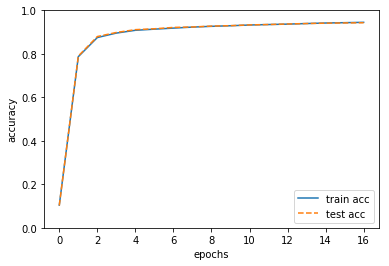

In [59]:
import matplotlib.pyplot as plt
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()